In [1]:
import torch
import joblib
import pickle
import pandas as pd
import numpy as np
from functions import auroc_curve, evaluation, rm, complete_confusion_matrix_robust, evaluation_robustness, complete_confusion_matrix
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame(columns=["Model", "AUROC", "Accuracy", "F1", "Recall", "Precision"])
model_results = pd.DataFrame(columns=["Model", "AUROC", "Accuracy", "F1", "Recall", "Precision"])

path_csv = "../../../Thesis_data/processed_data/"
path_model = "../../../Thesis_data/Models/"

In [2]:
X_test = rm(pd.read_csv(path_csv + "ontime_reporting_X_test.csv"))
y_test = np.ravel(pd.read_csv(path_csv + "ontime_reporting_y_test.csv"))

Memory usage of dataframe is 314.23 MB
Memory usage after optimization is: 78.56 MB
Decreased by 75.0%


## Evaluate Logistic Regression baseline model

In [3]:
logreg_baseline = pickle.load(open(path_model + "logreg_baseline.pkl", "rb"))
y_pred_logreg_baseline = logreg_baseline.predict(X_test)
y_pred_prob_logreg_baseline = logreg_baseline.predict_proba(X_test)[:, 1]

AUROC Score:  0.739
Accuracy Score:  0.841
Balanced Accuracy Score:  0.663
F1 Score:  0.473
Recall Score:  0.377
Precision Score:  0.634


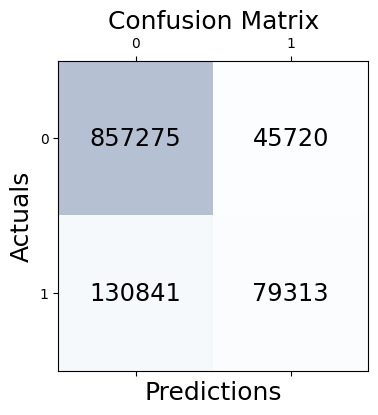

In [4]:
evaluation(y_test, y_pred_logreg_baseline, logreg_baseline, y_pred_prob_logreg_baseline, results)

## Evaluate XGBoost baseline model

In [4]:
xgb_class_baseline = pickle.load(open(path_model + "XGBoost_baseline.pkl", "rb")) #xgb version 1.7.5
y_pred_xgb_baseline = xgb_class_baseline.predict(X_test)
y_pred_prob_xgb_baseline = xgb_class_baseline.predict_proba(X_test)[:, 1]

AUROC Score:  0.794
Accuracy Score:  0.849
Balanced Accuracy Score:  0.665
F1 Score:  0.48
Recall Score:  0.371
Precision Score:  0.682


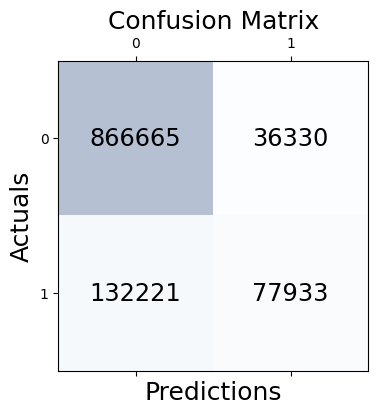

In [6]:
evaluation(y_test, y_pred_xgb_baseline, xgb_class_baseline, y_pred_prob_xgb_baseline, results)

## Evaluate TabNet baseline model

In [5]:
tabnet_baseline = torch.load(path_model + "TabNet_baseline.pt")
y_pred_tabnet_baseline = tabnet_baseline.predict(X_test.values)
y_pred_prob_tabnet_baseline = tabnet_baseline.predict_proba(X_test.values)[:, 1]

AUROC Score:  0.774
Accuracy Score:  0.846
Balanced Accuracy Score:  0.662
F1 Score:  0.473
Recall Score:  0.367
Precision Score:  0.666


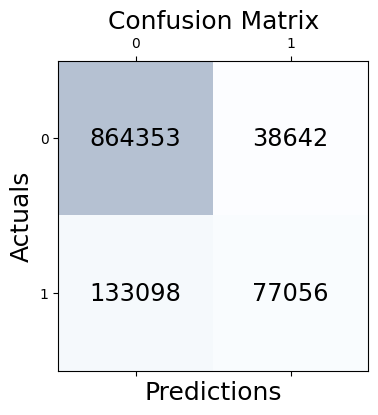

In [8]:
evaluation(y_test, y_pred_tabnet_baseline, tabnet_baseline, y_pred_prob_tabnet_baseline, results)

## Evaluate Random Forests baseline model

In [6]:
rf_baseline = joblib.load(path_model + "rf_baseline.joblib")
y_pred_rf_baseline = rf_baseline.predict(X_test)
y_pred_prob_rf_baseline = rf_baseline.predict_proba(X_test)[:, 1]

AUROC Score:  0.797
Accuracy Score:  0.85
Balanced Accuracy Score:  0.669
F1 Score:  0.488
Recall Score:  0.378
Precision Score:  0.688


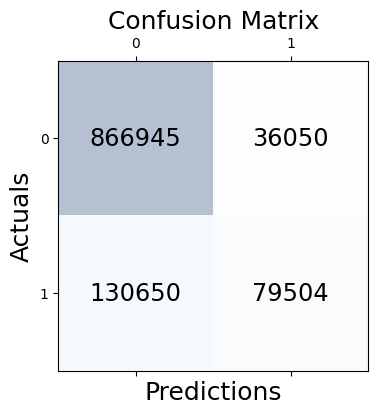

In [10]:
evaluation(y_test, y_pred_rf_baseline, rf_baseline, y_pred_prob_rf_baseline, results)

## Final Results per model

In [11]:
results.sort_values(by=["AUROC"], ascending=False)

,Model,AUROC,Accuracy,F1,Recall,Precision
4,RandomForestClassifier,0.797,0.850,0.488,0.378,0.688
2,XGBClassifier,0.794,0.849,0.480,0.371,0.682
3,TabNetClassifier,0.774,0.846,0.473,0.367,0.666
1,LogisticRegression,0.739,0.841,0.473,0.377,0.634


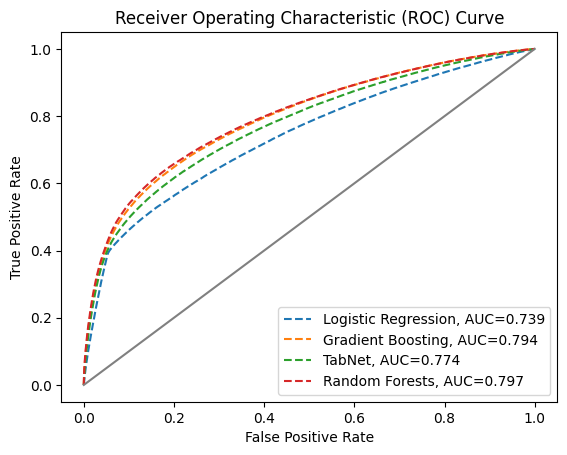

<Figure size 1400x1200 with 0 Axes>

In [14]:
auroc_curve(y_test, y_pred_prob_logreg_baseline, y_pred_prob_xgb_baseline, y_pred_prob_tabnet_baseline, y_pred_prob_rf_baseline)

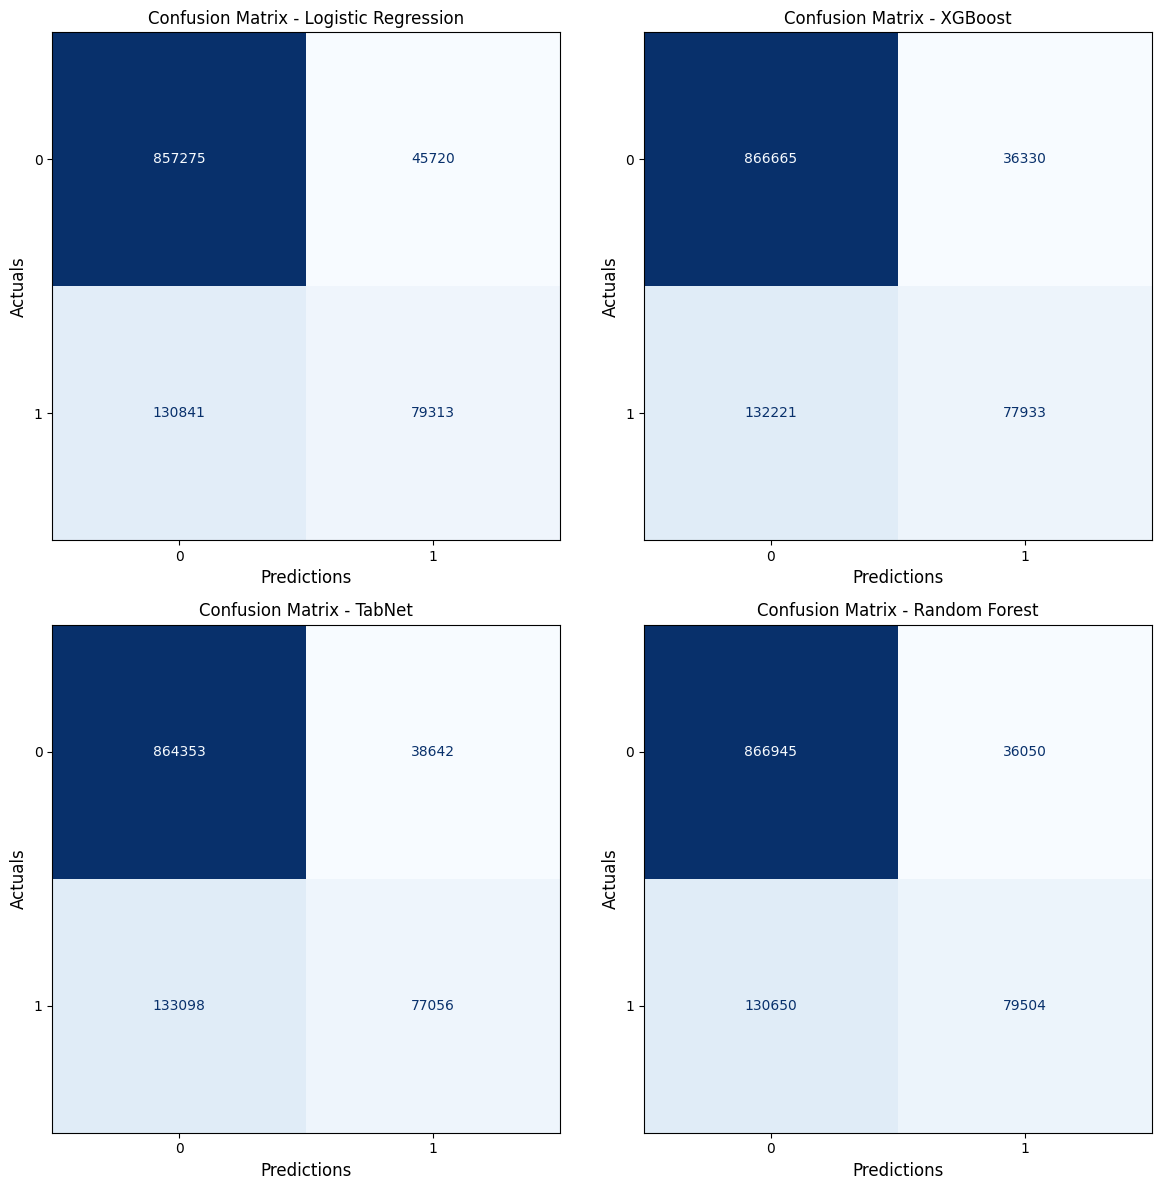

In [7]:
complete_confusion_matrix(y_test, [y_pred_logreg_baseline, y_pred_xgb_baseline, y_pred_tabnet_baseline, y_pred_rf_baseline], ['Logistic Regression', 'XGBoost', 'TabNet', 'Random Forest'])